# **DLAI PROJECT**

Project created by Carles Garcia Cabrera (Group 13), student of DLAI during autumm 2019, under the supervison of Noé Casas and Xavier Giró.

The project is broken down in 4 different parts:
  - Exercise 1: Convolutional Autoencoder
  - Exercise 2: Transfer Learning
  - Optional exercise A: Variational Autoencoder
  - Optional exercise B: Conditional GAN

During the whole notebook I will try to explain what I want to do before coding it and along the code I will comment the commands that I feel are most important.

# **Let's start!**
First of all the imports for the packages I am going to use:

In [0]:
#Core libraries
import numpy as np
np.random.seed(1)

import torch
import torch.optim as optim
torch.manual_seed(1)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(1)
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from tabulate import tabulate
from statistics import mean

import copy

#GPU Enabling
if not torch.cuda.is_available():
    raise Exception("You should enable GPU in the runtime menu.")
device = torch.device("cuda:0")

# **Exercise 1: Convolutional Autoencoder**
First we will load the **MNIST dataset** and then we will split the trainig data into 95% train and 5% validation.

In [2]:
#Train import
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))
                                    ]))
##Split train into train and val
mnist_trainset, mnist_valset = torch.utils.data.random_split(mnist_trainset, [int(len(mnist_trainset)*0.95),int(len(mnist_trainset)*0.05)])

#Test
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (0.5,))
                               ]))


0it [00:00, ?it/s]

9920512it [00:03, 3115230.39it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 48647.08it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:02, 801403.77it/s]                             
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 18076.58it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


And now some hyperparametes that we will use during the exercise:

In [0]:
hparams = {
    'batch_size':128,
    'num_epochs':30,
    'num_epochs2':1000,
    'num_epochs3':500,
    'num_epochs4':2000,
    'test_batch_size':64,
    'hidden1':64,
    'hidden2':128,
    'bottleneck1':10,
    'bottleneck2':50,
    'bottleneck3':100,
    'learning_rate':1e-3,
    'log_interval': 100
}
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

And now the dataloaders:

In [0]:
train_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

val_loader = torch.utils.data.DataLoader(
    mnist_valset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)

Now we will implement three different **autoencoders**, the difference is the bottleneck size.

In [0]:
class autoencoder1(nn.Module):
  def __init__(self, hparams):
    super(autoencoder1,self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, hparams['hidden1'], 4, stride = 2, padding = 1), 
        nn.ReLU(True),
        nn.Conv2d(hparams['hidden1'], hparams['hidden2'], 4, stride = 2, padding = 1),
        nn.ReLU(True),
    )

    self.linear1 = nn.Linear(hparams['hidden2']*7*7, hparams['bottleneck1'])
    self.linear2 = nn.Linear(hparams['bottleneck1'], hparams['hidden2']*7*7)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(hparams['hidden2'], hparams['hidden1'], 4, stride = 2, padding = 1),
        nn.ReLU(True),
        nn.ConvTranspose2d(hparams['hidden1'], 1, 4, stride = 2, padding = 1),
        nn.Tanh()
    )
  
  def forward(self, x):
    x = self.encoder(x)
    #bottleneck
    x = x.view(x.size(0), -1)
    x = self.linear1(x)
    x = self.linear2(x)
    x = x.view(x.size(0), hparams['hidden2'], 7, 7)
    ##
    y = self.decoder(x)
    return y

class autoencoder2(nn.Module):
  def __init__(self, hparams):
    super(autoencoder2,self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, hparams['hidden1'], 4, stride = 2, padding = 1), 
        nn.ReLU(True),
        nn.Conv2d(hparams['hidden1'], hparams['hidden2'], 4, stride = 2, padding = 1),
        nn.ReLU(True),
    )

    self.linear1 = nn.Linear(hparams['hidden2']*7*7, hparams['bottleneck2'])
    self.linear2 = nn.Linear(hparams['bottleneck2'], hparams['hidden2']*7*7)
    self.relu = nn.ReLU()

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(hparams['hidden2'], hparams['hidden1'], 4, stride = 2, padding = 1),
        nn.ReLU(True),
        nn.ConvTranspose2d(hparams['hidden1'], 1, 4, stride = 2, padding = 1),
        nn.Tanh()
    )
  
  def forward(self, x):
    x = self.encoder(x)
    #bottleneck
    x = x.view(x.size(0), -1)
    x = self.linear1(x)
    x = self.linear2(x)
    x = x.view(x.size(0), hparams['hidden2'], 7, 7)
    ##
    y = self.decoder(x)
    return y

class autoencoder3(nn.Module):
  def __init__(self, hparams):
    super(autoencoder3,self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, hparams['hidden1'], 4, stride = 2, padding = 1), 
        nn.ReLU(True),
        nn.Conv2d(hparams['hidden1'], hparams['hidden2'], 4, stride = 2, padding = 1),
        nn.ReLU(True),
    )

    self.linear1 = nn.Linear(hparams['hidden2']*7*7, hparams['bottleneck3'])
    self.linear2 = nn.Linear(hparams['bottleneck3'], hparams['hidden2']*7*7)
    self.relu = nn.ReLU()

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(hparams['hidden2'], hparams['hidden1'], 4, stride = 2, padding = 1),
        nn.ReLU(True),
        nn.ConvTranspose2d(hparams['hidden1'], 1, 4, stride = 2, padding = 1),
        nn.Tanh()
    )
  
  def forward(self, x):
    x = self.encoder(x)
    #bottleneck
    x = x.view(x.size(0), -1)
    x = self.linear1(x)
    x = self.linear2(x)
    x = x.view(x.size(0), hparams['hidden2'], 7, 7)
    ##
    y = self.decoder(x)
    return y

# **FAIL!**

In [0]:
class autoencoder(nn.Module):
  def __init__(self, hparams):
    super(autoencoder,self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, hparams['hidden1'], 3, padding = 1), 
        nn.ReLU(True),
        nn.MaxPool2d(2,2),
        nn.Conv2d(hparams['hidden1'], hparams['hidden2'], 3, padding = 1),
        nn.ReLU(True),
        nn.MaxPool2d(2,2),
        nn.Conv2d(hparams['hidden2'], hparams['hidden3'], 3, padding = 1),
        nn.ReLU(True),
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(hparams['hidden3'], hparams['hidden2'], 2, stride = 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(hparams['hidden2'], hparams['hidden1'], 2, stride = 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(hparams['hidden1'], 1, 1, stride = 1),
        nn.Sigmoid()
    )
  
  def forward(self, x):
    #print(x.shape)
    x = self.encoder(x)
    #print(x.shape)
    y = self.decoder(x)
    #print(y.shape)
    return y

# **FAIL!**

In [0]:
class autoencoder(nn.Module):
  def __init__(self, hparams):
    super().__init__()
    #Convs
    self.conv1 = nn.Conv2d(1, hparams['hidden1'], 3, padding = 1)
    self.conv11 = nn.Conv2d(hparams['hidden1'], hparams['hidden1'], 3, padding = 1)
    self.conv2 = nn.Conv2d(hparams['hidden1'], hparams['hidden2'], 3, padding = 1)
    self.conv22 = nn.Conv2d(hparams['hidden2'], hparams['hidden2'], 3, padding = 1)
    self.conv3 = nn.Conv2d(hparams['hidden2'], hparams['hidden3'], 3, padding = 1)
    self.conv33 = nn.Conv2d(hparams['hidden3'], hparams['hidden3'], 3, padding = 1)
    #Maxpool
    self.maxpool = nn.MaxPool2d(2)
    #UpConvs
    self.upconv1 = nn.ConvTranspose2d(hparams['hidden3'],hparams['hidden2'],2, stride = 2)
    self.upconv2 = nn.ConvTranspose2d(hparams['hidden2'],hparams['hidden1'],2, stride = 2)
    #To 1 channel
    self.upconv3 = nn.ConvTranspose2d(hparams['hidden1'],1,1, stride = 1,)
    #Conv1x1
    self.conv1x1 = nn.Conv2d(1,1,1) 
    #Activations
    self.relu = nn.ReLU()
    self.sigm = nn.Sigmoid()


  def forward(self, x):
    #Encoder x =(28x28,1)
    x = self.conv1(x) #(28x28,32)
    x = self.relu(x)
    x = self.conv11(x) 
    x = self.relu(x)
    x = self.maxpool(x) #(14,14,32) 
    x = self.conv2(x) #First down arrow (14,14,64)
    x = self.relu(x)
    x = self.conv22(x)
    x = self.relu(x)
    x = self.maxpool(x) #(7,7,64)
    ## Second down arrow 
    ## -> Bottle neck
    x = self.conv3(x) #(7,7,128)
    x = self.relu(x)
    x = self.conv33(x)
    x = self.relu(x)
    #Decoder
    x = self.upconv1(x) #First up arrow (14,14,64)
    x = self.relu(x)
    x = self.conv22(x)
    x = self.relu(x)
    x = self.upconv2(x) #Second up arrow (28,28,32)
    x = self.relu(x)
    x = self.conv11(x)
    x = self.relu(x)
    x = self.upconv3(x) # (28,28,1)
    y = self.sigm(x)
    return y

Now, let's define the **training**:

In [0]:
def train_epoch(train_loader, network, optimizer, criterion, hparams, epoch):
  network.train()
  device = hparams['device']
  losses = []
  for batch_idx, (data, target) in enumerate(train_loader, 1):
      data = data.to(device)
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, data)
      loss.backward()
      losses.append(loss.item())
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0 or batch_idx >= len(train_loader):
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()
              ))
  return np.mean(losses)

def eval_epoch(val_loader, network, criterion, hparams):
  network.eval()
  device = hparams['device']
  eval_loss = 0
  with torch.no_grad():
      for data, target in val_loader:
          data = data.to(device)
          output = network(data)
          eval_loss += criterion(output, data).item() 
  eval_loss /= len(val_loader.dataset)
  print('Eval set: Average loss: {:.4f}'.format(
      eval_loss*100, len(val_loader.dataset),
      ))
  return eval_loss*100

def train_net(network, train_loader, eval_loader, optimizer, num_epochs, plot=True):
  tr_losses = []
  te_losses = []

  network.to(hparams['device'])
  criterion = nn.MSELoss()

  for epoch in range(1, num_epochs + 1):
    tr_loss = train_epoch(train_loader, network, optimizer, criterion, hparams, epoch)
    te_loss = eval_epoch(eval_loader, network, criterion, hparams)
    te_losses.append(te_loss)
    tr_losses.append(tr_loss)
  rets = {'tr_losses':tr_losses, 'te_losses':te_losses}
  if plot:
    plt.figure(figsize=(10, 8))
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('NLLLoss')
    plt.plot(tr_losses, label='Train')
    plt.plot(te_losses, label='Eval')
    plt.legend()
  return rets

Model, criterion and optimizer:

In [0]:
criterion = nn.MSELoss()

model1 = autoencoder1(hparams).cuda()
optimizer1 = torch.optim.Adam(model1.parameters(), lr = hparams['learning_rate'],
                             weight_decay = 1e-5)
num_params1 = sum(p.numel() for p in model1.parameters() if p.requires_grad)

model2 = autoencoder2(hparams).cuda()
optimizer2 = torch.optim.Adam(model2.parameters(), lr = hparams['learning_rate'],
                             weight_decay = 1e-5)
num_params2 = sum(p.numel() for p in model2.parameters() if p.requires_grad)

model3 = autoencoder3(hparams).cuda()
optimizer3 = torch.optim.Adam(model3.parameters(), lr = hparams['learning_rate'],
                             weight_decay = 1e-5)
num_params3 = sum(p.numel() for p in model3.parameters() if p.requires_grad)

Let's **TRAIN**

Train Epoch: 1 [12800/57000 (22%)]	Loss: 0.111580
Train Epoch: 1 [25600/57000 (45%)]	Loss: 0.096076
Train Epoch: 1 [38400/57000 (67%)]	Loss: 0.082491
Train Epoch: 1 [51200/57000 (90%)]	Loss: 0.074157
Train Epoch: 1 [17840/57000 (100%)]	Loss: 0.067941
Eval set: Average loss: 0.0598
Train Epoch: 2 [12800/57000 (22%)]	Loss: 0.068979
Train Epoch: 2 [25600/57000 (45%)]	Loss: 0.069852
Train Epoch: 2 [38400/57000 (67%)]	Loss: 0.070459
Train Epoch: 2 [51200/57000 (90%)]	Loss: 0.061533
Train Epoch: 2 [17840/57000 (100%)]	Loss: 0.067567
Eval set: Average loss: 0.0511
Train Epoch: 3 [12800/57000 (22%)]	Loss: 0.062713
Train Epoch: 3 [25600/57000 (45%)]	Loss: 0.061126
Train Epoch: 3 [38400/57000 (67%)]	Loss: 0.058674
Train Epoch: 3 [51200/57000 (90%)]	Loss: 0.062396
Train Epoch: 3 [17840/57000 (100%)]	Loss: 0.066953
Eval set: Average loss: 0.0482
Train Epoch: 4 [12800/57000 (22%)]	Loss: 0.059744
Train Epoch: 4 [25600/57000 (45%)]	Loss: 0.064880
Train Epoch: 4 [38400/57000 (67%)]	Loss: 0.053380
Trai

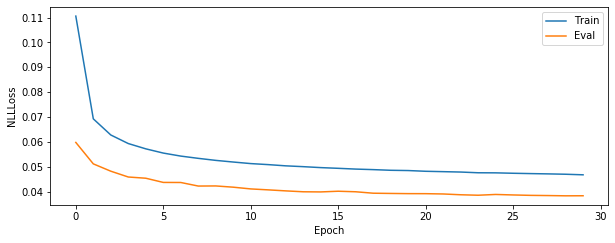

In [8]:
autoen1 = train_net(model1, train_loader, val_loader, optimizer1, hparams['num_epochs'])

Train Epoch: 1 [12800/57000 (22%)]	Loss: 0.078223
Train Epoch: 1 [25600/57000 (45%)]	Loss: 0.034420
Train Epoch: 1 [38400/57000 (67%)]	Loss: 0.024731
Train Epoch: 1 [51200/57000 (90%)]	Loss: 0.021118
Train Epoch: 1 [17840/57000 (100%)]	Loss: 0.019150
Eval set: Average loss: 0.0158
Train Epoch: 2 [12800/57000 (22%)]	Loss: 0.018246
Train Epoch: 2 [25600/57000 (45%)]	Loss: 0.015438
Train Epoch: 2 [38400/57000 (67%)]	Loss: 0.016325
Train Epoch: 2 [51200/57000 (90%)]	Loss: 0.014314
Train Epoch: 2 [17840/57000 (100%)]	Loss: 0.013451
Eval set: Average loss: 0.0110
Train Epoch: 3 [12800/57000 (22%)]	Loss: 0.012889
Train Epoch: 3 [25600/57000 (45%)]	Loss: 0.014397
Train Epoch: 3 [38400/57000 (67%)]	Loss: 0.011280
Train Epoch: 3 [51200/57000 (90%)]	Loss: 0.011940
Train Epoch: 3 [17840/57000 (100%)]	Loss: 0.012325
Eval set: Average loss: 0.0099
Train Epoch: 4 [12800/57000 (22%)]	Loss: 0.012124
Train Epoch: 4 [25600/57000 (45%)]	Loss: 0.010997
Train Epoch: 4 [38400/57000 (67%)]	Loss: 0.011281
Trai

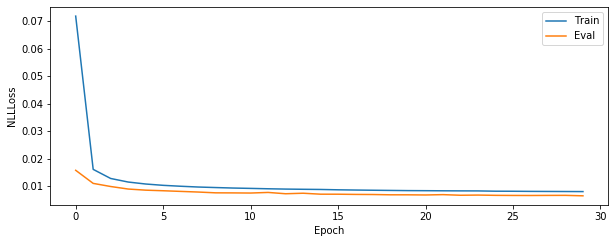

In [9]:
autoen2 = train_net(model2, train_loader, val_loader, optimizer2, hparams['num_epochs'])

Train Epoch: 1 [12800/57000 (22%)]	Loss: 0.077523
Train Epoch: 1 [25600/57000 (45%)]	Loss: 0.031343
Train Epoch: 1 [38400/57000 (67%)]	Loss: 0.020099
Train Epoch: 1 [51200/57000 (90%)]	Loss: 0.017135
Train Epoch: 1 [17840/57000 (100%)]	Loss: 0.018381
Eval set: Average loss: 0.0131
Train Epoch: 2 [12800/57000 (22%)]	Loss: 0.014815
Train Epoch: 2 [25600/57000 (45%)]	Loss: 0.013195
Train Epoch: 2 [38400/57000 (67%)]	Loss: 0.011474
Train Epoch: 2 [51200/57000 (90%)]	Loss: 0.011424
Train Epoch: 2 [17840/57000 (100%)]	Loss: 0.010789
Eval set: Average loss: 0.0084
Train Epoch: 3 [12800/57000 (22%)]	Loss: 0.009599
Train Epoch: 3 [25600/57000 (45%)]	Loss: 0.009326
Train Epoch: 3 [38400/57000 (67%)]	Loss: 0.008820
Train Epoch: 3 [51200/57000 (90%)]	Loss: 0.009161
Train Epoch: 3 [17840/57000 (100%)]	Loss: 0.009186
Eval set: Average loss: 0.0069
Train Epoch: 4 [12800/57000 (22%)]	Loss: 0.007831
Train Epoch: 4 [25600/57000 (45%)]	Loss: 0.008438
Train Epoch: 4 [38400/57000 (67%)]	Loss: 0.007225
Trai

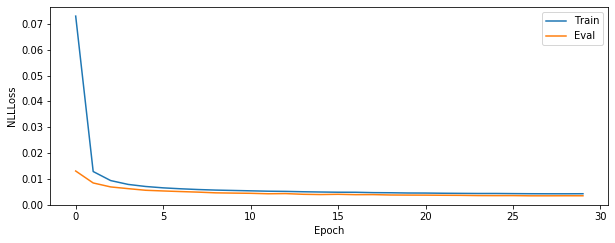

In [10]:
autoen3 = train_net(model3, train_loader, val_loader, optimizer3, hparams['num_epochs'])

We can see how, the bigger the bottleneck and hence the smaller the compression, the smaller the loss.

Let's plot all the curves in the same chart:

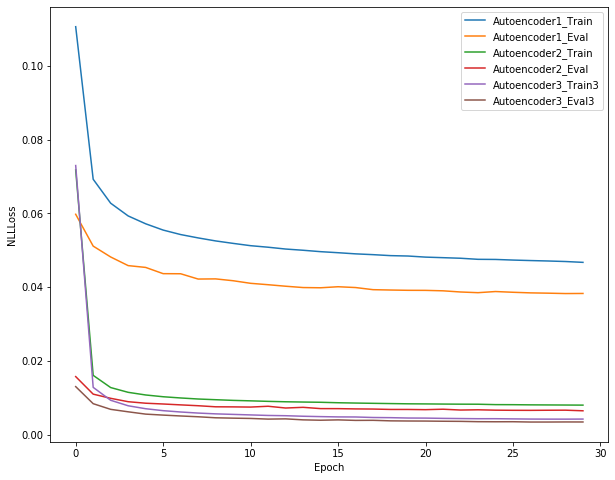

In [11]:
train_loss1 = autoen1["tr_losses"]
val_loss1 = autoen1["te_losses"]

train_loss2 = autoen2["tr_losses"]
val_loss2 = autoen2["te_losses"]

train_loss3 = autoen3["tr_losses"]
val_loss3 = autoen3["te_losses"]

plt.figure(figsize=(10, 8))
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')
plt.plot(train_loss1, label='Autoencoder1_Train')
plt.plot(val_loss1, label='Autoencoder1_Eval')
plt.plot(train_loss2, label='Autoencoder2_Train')
plt.plot(val_loss2, label='Autoencoder2_Eval')
plt.plot(train_loss3, label='Autoencoder3_Train3')
plt.plot(val_loss3, label='Autoencoder3_Eval3')
plt.legend()

Now we need to define the **testing**:

In [0]:
def test_model(network, test_loader):
  network.eval()
  test_loss_avg = 0
  num_batches = 0
  for data, _ in test_loader:
      with torch.no_grad():
          data = data.to(device)
          data_recon = network(data)
          loss = F.mse_loss(data_recon, data)
          test_loss_avg += loss.item()
          num_batches += 1  
  test_loss_avg /= num_batches
  print('Average Reconstruction Error: %f' % (test_loss_avg))
  return test_loss_avg

And compute the testing set:

In [13]:
test_autoen1 = test_model(model1, test_loader)
test_autoen2 = test_model(model2, test_loader)
test_autoen3 = test_model(model3, test_loader)

Average Reconstruction Error: 0.048085
Average Reconstruction Error: 0.008026
Average Reconstruction Error: 0.004259


Let's wrapp up our results so far:

In [14]:
print(tabulate([
                ['Autoencoder1(10)', mean(val_loss1), test_autoen1, num_params1], 
                ['Autoencoder2(50)', mean(val_loss2), test_autoen2, num_params2], 
                ['Autoencoder3(100)', mean(val_loss3), test_autoen3, num_params3]
                ], 
               headers=['Model(Bottleneck size)', 'MSE_val', 'MSE_test', 'Num_params']
               )
)

Model(Bottleneck size)       MSE_val    MSE_test    Num_params
------------------------  ----------  ----------  ------------
Autoencoder1(10)          0.0416566   0.0480854         396171
Autoencoder2(50)          0.00775763  0.00802607        897971
Autoencoder3(100)         0.0046924   0.00425861       1525221


Good, but we better check how they look like and compare with our input data.

Using model1(Bottleneck = 10)
---------------------------------
Original images


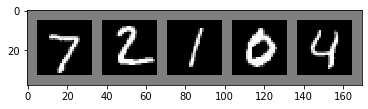

Autoencoder reconstruction:


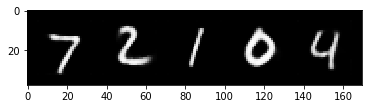

In [17]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):
    with torch.no_grad():
        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = utils.make_grid(images[0:5],5, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

from random import sample, randint
images, _ = iter(test_loader).next()
model1.eval()
print('Using model1(Bottleneck = 10)')
print('---------------------------------')
# First visualise the original images
print('Original images')
show_image(utils.make_grid(images[0:5],5,5))
plt.show()
# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, model1)

What if we **inject noise** in the decoder's input?

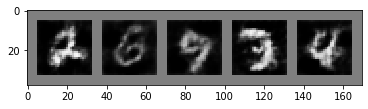

In [19]:
model1.eval()

with torch.no_grad():
  images, labels = iter(test_loader).next()
  images = images.to(device)
  latent = model1.encoder(images)
  latent = latent.view(latent.size(0), -1)
  latent = model1.linear1(latent)
  latent = latent.cpu()

  mean = latent.mean(dim=0)
  std = (latent - mean).pow(2).mean(dim=0).sqrt()

  latent = torch.randn(128, 10)*std + mean

  # reconstruct images from the latent vectors
  latent = latent.to(device)
  img_recon = model1.linear2(latent)
  img_recon = img_recon.view(img_recon.size(0), hparams['hidden2'], 7, 7)
  img_recon = model1.relu(img_recon)
  img_recon = model1.decoder(img_recon)
  img_recon = img_recon.cpu()

  show_image(utils.make_grid(img_recon[:5],5,5))
  plt.show()

# **Exercise 2: Transfer Learning**


In this exercise we will reuse the encoding part of Model1 of the exercise 1 to classify the images into their corresponding number. To achieve that we will build several approaches and afterwards we will compare them.



First of all we will get a subset of 100 images from our training set.

In [0]:
mnist_trainset2, _ = torch.utils.data.random_split(mnist_trainset, [int(len(mnist_trainset)/570),int(len(mnist_trainset)*569/570)])

In [0]:
train_loader2 = torch.utils.data.DataLoader(
    mnist_trainset2,
    batch_size=hparams['batch_size'], 
    shuffle=True)

And we will use, as said, the model1

In [0]:
ex2model1 = copy.deepcopy(model1)
ex2model2 = copy.deepcopy(model1)
ex2model3 = autoencoder1(hparams).cuda()

And now we will create a digit (0-9) classification model **reusing the encoder of the autoencoder** and adding what is needed.

First we define the training for this particular problem

In [0]:
def train_epoch2(train_loader, network, optimizer, criterion, hparams, epoch):
  network.train()
  device = hparams['device']
  losses = []
  for batch_idx, (data, target) in enumerate(train_loader, 1):
      data = data.to(device)
      target = target.to(device)
      optimizer.zero_grad()

      #Using the encoder + linear + softmax
      output = network.encoder(data)
      output = output.view(output.size(0), -1)
      output = network.linear1(output)
      output = network.softmax(output)

      loss = criterion(output, target)
      loss.backward()
      losses.append(loss.item())
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0 or batch_idx >= len(train_loader):
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()
              ))
  return np.mean(losses)

def train_net2(network, train_loader, optimizer, num_epochs, criterion):
  tr_losses = []

  network.to(hparams['device'])

  for epoch in range(1, num_epochs + 1):
    tr_loss = train_epoch2(train_loader, network, optimizer, criterion, hparams, epoch)
    tr_losses.append(tr_loss)
  rets = {'tr_losses':tr_losses}
  return rets

The first approach will be to use **pre-training**, which is using the weights of the autoencoder as initial values for the network weights and train a classification model on the subset of 100 samples.

Criterion and optimizer

In [0]:
ex2criterion = nn.CrossEntropyLoss()
ex2optimizer1 = torch.optim.Adam(ex2model1.parameters(), lr = hparams['learning_rate'],
                             weight_decay = 1e-5)

Training

In [25]:
classifier1 = train_net2(ex2model1, train_loader2, ex2optimizer1, hparams['num_epochs2'], ex2criterion)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Train Epoch: 1 [100/100 (100%)]	Loss: 2.346251
Train Epoch: 2 [100/100 (100%)]	Loss: 2.325722
Train Epoch: 3 [100/100 (100%)]	Loss: 2.304563
Train Epoch: 4 [100/100 (100%)]	Loss: 2.282768
Train Epoch: 5 [100/100 (100%)]	Loss: 2.259653
Train Epoch: 6 [100/100 (100%)]	Loss: 2.234435
Train Epoch: 7 [100/100 (100%)]	Loss: 2.206271
Train Epoch: 8 [100/100 (100%)]	Loss: 2.175637
Train Epoch: 9 [100/100 (100%)]	Loss: 2.144656
Train Epoch: 10 [100/100 (100%)]	Loss: 2.116192
Train Epoch: 11 [100/100 (100%)]	Loss: 2.088499
Train Epoch: 12 [100/100 (100%)]	Loss: 2.056522
Train Epoch: 13 [100/100 (100%)]	Loss: 2.018424
Train Epoch: 14 [100/100 (100%)]	Loss: 1.978335
Train Epoch: 15 [100/100 (100%)]	Loss: 1.940467
Train Epoch: 16 [100/100 (100%)]	Loss: 1.903726
Train Epoch: 17 [100/100 (100%)]	Loss: 1.872588
Train Epoch: 18 [100/100 (100%)]	Loss: 1.847575
Train Epoch: 19 [100/100 (100%)]	Loss: 1.824475
Train Epoch: 20 [100/100 (100%)]	Loss: 1.801901
Train Epoch: 21 [100/100 (100%)]	Loss: 1.781543
T

Now we will use **fine-tuning**, which is doing the same, but training the new projection layer with a normal learning rate and the reused part with a very low learning rate.


In [0]:
ex2optimizer2 = torch.optim.Adam([
    {"params": ex2model2.encoder.parameters(), "lr": 1e-4},
    {"params": ex2model2.linear1.parameters(), "lr": 1e-3}],
    lr = 1e-4, 
    weight_decay = 1e-5
    )

Training

In [27]:
classifier2 = train_net2(ex2model2, train_loader2, ex2optimizer2, hparams['num_epochs3'], ex2criterion)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Train Epoch: 1 [100/100 (100%)]	Loss: 2.346251
Train Epoch: 2 [100/100 (100%)]	Loss: 2.336316
Train Epoch: 3 [100/100 (100%)]	Loss: 2.325684
Train Epoch: 4 [100/100 (100%)]	Loss: 2.314358
Train Epoch: 5 [100/100 (100%)]	Loss: 2.302344
Train Epoch: 6 [100/100 (100%)]	Loss: 2.289626
Train Epoch: 7 [100/100 (100%)]	Loss: 2.276194
Train Epoch: 8 [100/100 (100%)]	Loss: 2.262045
Train Epoch: 9 [100/100 (100%)]	Loss: 2.247193
Train Epoch: 10 [100/100 (100%)]	Loss: 2.231645
Train Epoch: 11 [100/100 (100%)]	Loss: 2.215457
Train Epoch: 12 [100/100 (100%)]	Loss: 2.198697
Train Epoch: 13 [100/100 (100%)]	Loss: 2.181482
Train Epoch: 14 [100/100 (100%)]	Loss: 2.163892
Train Epoch: 15 [100/100 (100%)]	Loss: 2.146031
Train Epoch: 16 [100/100 (100%)]	Loss: 2.128007
Train Epoch: 17 [100/100 (100%)]	Loss: 2.109905
Train Epoch: 18 [100/100 (100%)]	Loss: 2.091765
Train Epoch: 19 [100/100 (100%)]	Loss: 2.073599
Train Epoch: 20 [100/100 (100%)]	Loss: 2.055387
Train Epoch: 21 [100/100 (100%)]	Loss: 2.037091
T

Now we will start **from scratch**, which mean that we will train the model on the 100 samples without reusing the decoder weights at all.

In [0]:
ex2optimizer3 = torch.optim.Adam(ex2model3.parameters(), lr = hparams['learning_rate'],
                             weight_decay = 1e-5)

Let's train

In [29]:
classifier3 = train_net2(ex2model3, train_loader2, ex2optimizer3, hparams['num_epochs4'], ex2criterion)

Train Epoch: 1 [100/100 (100%)]	Loss: 2.302834
Train Epoch: 2 [100/100 (100%)]	Loss: 2.270785
Train Epoch: 3 [100/100 (100%)]	Loss: 2.233215
Train Epoch: 4 [100/100 (100%)]	Loss: 2.198313
Train Epoch: 5 [100/100 (100%)]	Loss: 2.154681
Train Epoch: 6 [100/100 (100%)]	Loss: 2.113549
Train Epoch: 7 [100/100 (100%)]	Loss: 2.071005
Train Epoch: 8 [100/100 (100%)]	Loss: 2.035726


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Train Epoch: 9 [100/100 (100%)]	Loss: 2.012658
Train Epoch: 10 [100/100 (100%)]	Loss: 1.988173
Train Epoch: 11 [100/100 (100%)]	Loss: 1.958632
Train Epoch: 12 [100/100 (100%)]	Loss: 1.847847
Train Epoch: 13 [100/100 (100%)]	Loss: 1.992564
Train Epoch: 14 [100/100 (100%)]	Loss: 1.820458
Train Epoch: 15 [100/100 (100%)]	Loss: 1.807931
Train Epoch: 16 [100/100 (100%)]	Loss: 1.819330
Train Epoch: 17 [100/100 (100%)]	Loss: 1.774567
Train Epoch: 18 [100/100 (100%)]	Loss: 1.768462
Train Epoch: 19 [100/100 (100%)]	Loss: 1.727270
Train Epoch: 20 [100/100 (100%)]	Loss: 1.705996
Train Epoch: 21 [100/100 (100%)]	Loss: 1.693706
Train Epoch: 22 [100/100 (100%)]	Loss: 1.680076
Train Epoch: 23 [100/100 (100%)]	Loss: 1.678339
Train Epoch: 24 [100/100 (100%)]	Loss: 1.670923
Train Epoch: 25 [100/100 (100%)]	Loss: 1.656426
Train Epoch: 26 [100/100 (100%)]	Loss: 1.649030
Train Epoch: 27 [100/100 (100%)]	Loss: 1.646889
Train Epoch: 28 [100/100 (100%)]	Loss: 1.646050
Train Epoch: 29 [100/100 (100%)]	Loss: 1.

Now let's **test** it

In [0]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def test_model2(network, test_loader, criterion):
  network.eval()
  test_loss_avg = 0
  num_batches = 0
  acc = 0
  for data, target in test_loader:
      with torch.no_grad():
          data = data.to(device)
          target = target.to(device)

          output = network.encoder(data)
          output = output.view(output.size(0), -1)
          output = network.linear1(output)
          output = network.softmax(output)

          acc += correct_predictions(output, target)

          num_batches += 1  
  test_acc = 100. * acc / len(test_loader.dataset)
  print('Test Acc: %f' % (test_acc))
  return test_acc

Test the 3 different models

In [31]:
test_classifier1 = test_model2(ex2model1, test_loader, ex2criterion)
test_classifier2 = test_model2(ex2model2, test_loader, ex2criterion)
test_classifier3 = test_model2(ex2model3, test_loader, ex2criterion)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test Acc: 66.870000
Test Acc: 83.510000
Test Acc: 78.000000


Let's sumarize the results

In [32]:
print(tabulate([
                ['Pre-training', test_classifier1], 
                ['Fine-tunning', test_classifier2], 
                ['From scratch', test_classifier3]
                ], 
               headers=['Classifier', 'Acc']
               )
)

Classifier      Acc
------------  -----
Pre-training  66.87
Fine-tunning  83.51
From scratch  78
